In [1]:
import numpy as np

class Perceptron:
    """Perception classifier.

    Parameters
    -----------
    eta : float
        Learning rate(between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        Random number generator see for random weight initialization


    Attributes
    ----------
    w_ : 1d-array
        Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.

    errors_ : list
        Number of misclassifications (updates) in each epoch.

    """

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of
            examples and n_features is the number of features.
        y : array-like, shape = [n_examples]
            Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_  = np.float64(0.)
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
            
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)


In [2]:
import os
import pandas as pd
s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
print('From URL:', s)

df = pd.read_csv(s, header=None, encoding='utf-8')
df.tail()

From URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


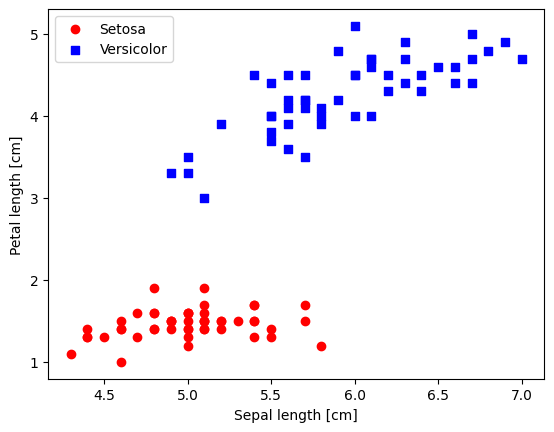

In [3]:
import matplotlib.pyplot as plt

# select setosa and versicolor
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)

# extract sepal length and petal length
X = df.iloc[0:100, [0, 2]].values

# plot data
plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='Setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='s', label='Versicolor')
plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')
plt.show()

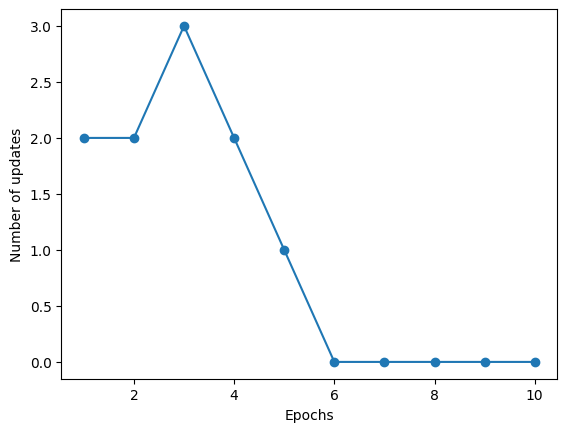

In [4]:
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.show()

In [5]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifer, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    lab = classifer.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl, 0],
                    y = X[y == cl, 1],
                    alpha = 0.8,
                    c = colors[idx],
                    marker = markers[idx],
                    label = f'Class {cl}',
                    edgecolor = 'black')

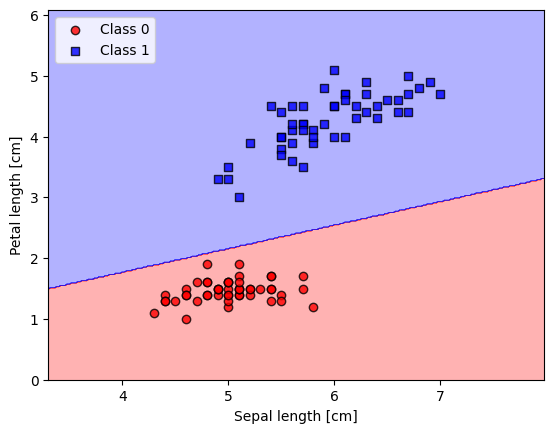

In [7]:
plot_decision_regions(X, y, classifer=ppn)
plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')
plt.show()

In [11]:
class AdalineGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    -----------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        Random number generator seed for random weight initialization.

    Attributes
    ----------
    w_ : 1d-array
        Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
        Mean squared error loss function values in each epoch.
    """

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_examples
            is the number of examples and
            n_features is the number of features.
        y : array-like, shape = [n_examples]
            Target values

        Returns
        -------
        self : object
        """

        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.0)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors ** 2).mean()
            self.losses_.append(loss)

        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

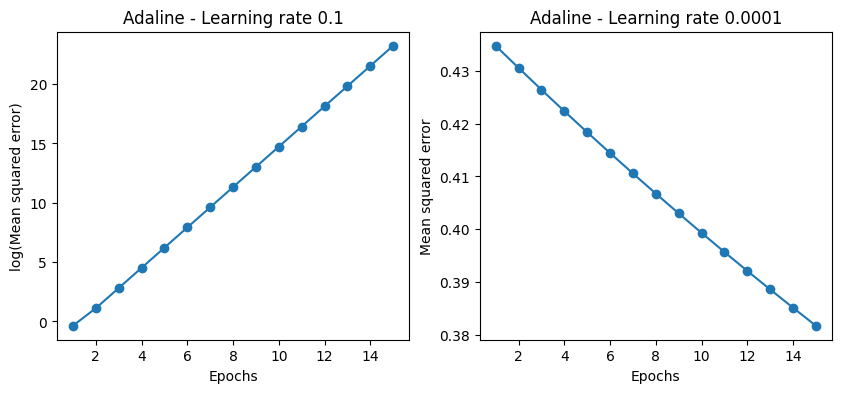

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ada1 = AdalineGD(n_iter=15, eta=0.1).fit(X, y)
ax[0].plot(range(1, len(ada1.losses_) + 1), np.log10(ada1.losses_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Mean squared error)')
ax[0].set_title('Adaline - Learning rate 0.1')
ada2 = AdalineGD(n_iter=15, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
ax[1].set_title('Adaline - Learning rate 0.0001')
plt.show()
